# Proyecto Inteligencia Computacional - Proyecto 8 - ID 8a

## Integrantes
- Juan Pablo Contreras
- Pascual Marcone

## Ayudante
- Sebastian Guzman

# Dependencias

In [1]:
#libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
importlib.reload(src)

import src.model.train as train
import src.model.ae as ae

import src.probing.linear_probing as lp

import src.utils.plots as plots
import src.utils.gau as gaussian
import src.utils.metrics as metrics

/home/pascual/miniforge3/envs/inteli_cpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Setup

In [2]:
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')

In [3]:
def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

rename_labels(stamps_dataset, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

### 5stamps_dataset

In [4]:
# Extract the template and difference data
train_template = torch.tensor(stamps_dataset['Train']['template'], dtype=torch.float32)
validation_template = torch.tensor(stamps_dataset['Validation']['template'], dtype=torch.float32)
test_template = torch.tensor(stamps_dataset['Test']['template'], dtype=torch.float32)

train_difference = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
validation_difference = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
test_difference = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)

train_image = torch.tensor(stamps_dataset['Train']['images'], dtype=torch.float32)
validation_image = torch.tensor(stamps_dataset['Validation']['images'], dtype=torch.float32)
test_image = torch.tensor(stamps_dataset['Test']['images'], dtype=torch.float32)

train_class_0 = torch.tensor(stamps_dataset['Train']['class'], dtype=torch.float32)
validation_class_0 = torch.tensor(stamps_dataset['Validation']['class'], dtype=torch.float32)
test_class_0 = torch.tensor(stamps_dataset['Test']['class'], dtype=torch.float32)

# Reshape the arrays to separate timestamps
num_samples, num_photos, height, width = train_difference.shape
reshaped_train_difference = train_difference.reshape(num_samples * num_photos, height, width)
reshaped_train_template = train_template.repeat_interleave(num_photos, dim=0)
reshaped_train_image = train_image.reshape(train_image.shape[0] * num_photos, height, width)
reshaped_train_class = train_class_0.repeat_interleave(num_photos)

num_samples, num_photos, height, width = validation_difference.shape
reshaped_val_difference = validation_difference.reshape(validation_difference.shape[0] * num_photos, height, width)
reshaped_val_template = validation_template.repeat_interleave(num_photos, dim=0)
reshaped_val_image = validation_image.reshape(validation_image.shape[0] * num_photos, height, width)
reshaped_val_class = validation_class_0.repeat_interleave(num_photos)

num_samples, num_photos, height, width = test_difference.shape
reshaped_test_difference = test_difference.reshape(test_difference.shape[0] * num_photos, height, width)
reshaped_test_template = test_template.repeat_interleave(num_photos, dim=0)
reshaped_test_image = test_image.reshape(test_image.shape[0] * num_photos, height, width)
reshaped_test_class = test_class_0.repeat_interleave(num_photos)

# Combine the template and difference into a 2-channel image
train_dataset = torch.stack((reshaped_train_template, reshaped_train_image, reshaped_train_difference), dim=3)
validation_dataset = torch.stack((reshaped_val_template, reshaped_val_image, reshaped_val_difference), dim=3)
test_dataset = torch.stack((reshaped_test_template, reshaped_test_image, reshaped_test_difference), dim=3)

train_dataset_0 = TensorDataset(train_dataset.permute(0, 3, 1, 2), reshaped_train_class)
validation_dataset_0 = TensorDataset(validation_dataset.permute(0, 3, 1, 2), reshaped_val_class)
test_dataset_0 = TensorDataset(test_dataset.permute(0, 3, 1, 2), reshaped_test_class)

In [5]:
from torch.utils.data import random_split

first = int(len(train_dataset_0)/4)
second = int(len(train_dataset_0)/4)
third = int(len(train_dataset_0)/4)
fourth = len(train_dataset_0) - (first + second + third)


train_subset_0_0, train_subset_0_1, train_subset_0_2, train_subset_0_3 = random_split(train_dataset_0, [first, second, third, fourth], generator=torch.Generator().manual_seed(42))

# Model Train

## Train with final database

Augmenting Data ... 
Starting training ...
Epoch 77/200 (Early Stop) -- Iteration 948871 - Batch 12322/12323 - Train loss: 0.00086787 - Val loss: 0.00030957Tiempo total de entrenamiento: 8432.70 [s]

Augmenting Data ... 
Starting training ...
Epoch 22/200 (Early Stop) -- Iteration 271106 - Batch 12322/12323 - Train loss: 0.00104847 - Val loss: 0.00027728Tiempo total de entrenamiento: 2434.11 [s]



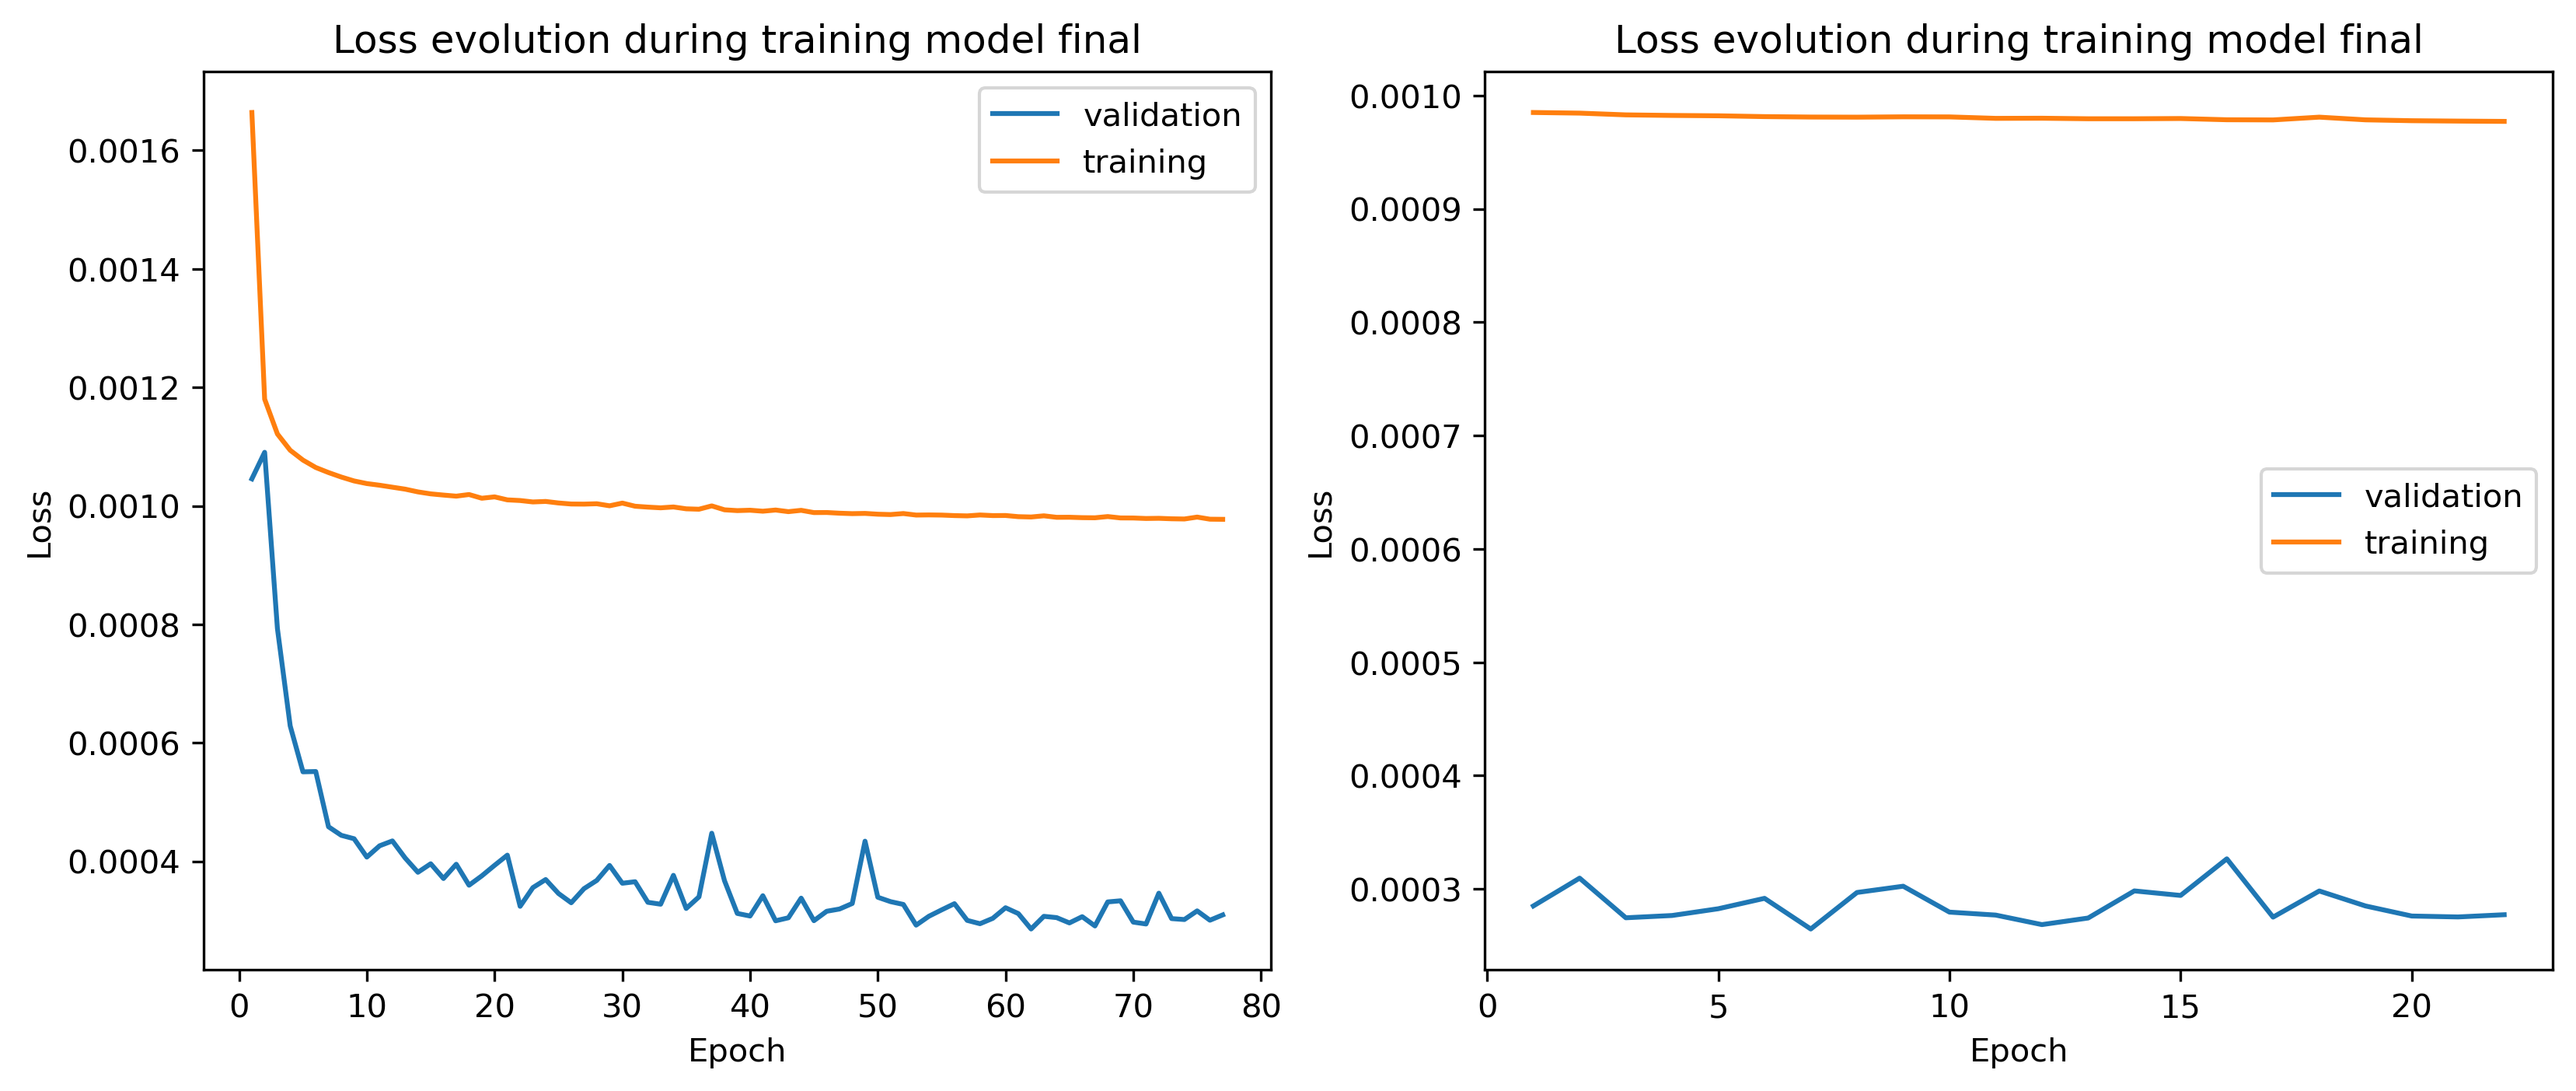

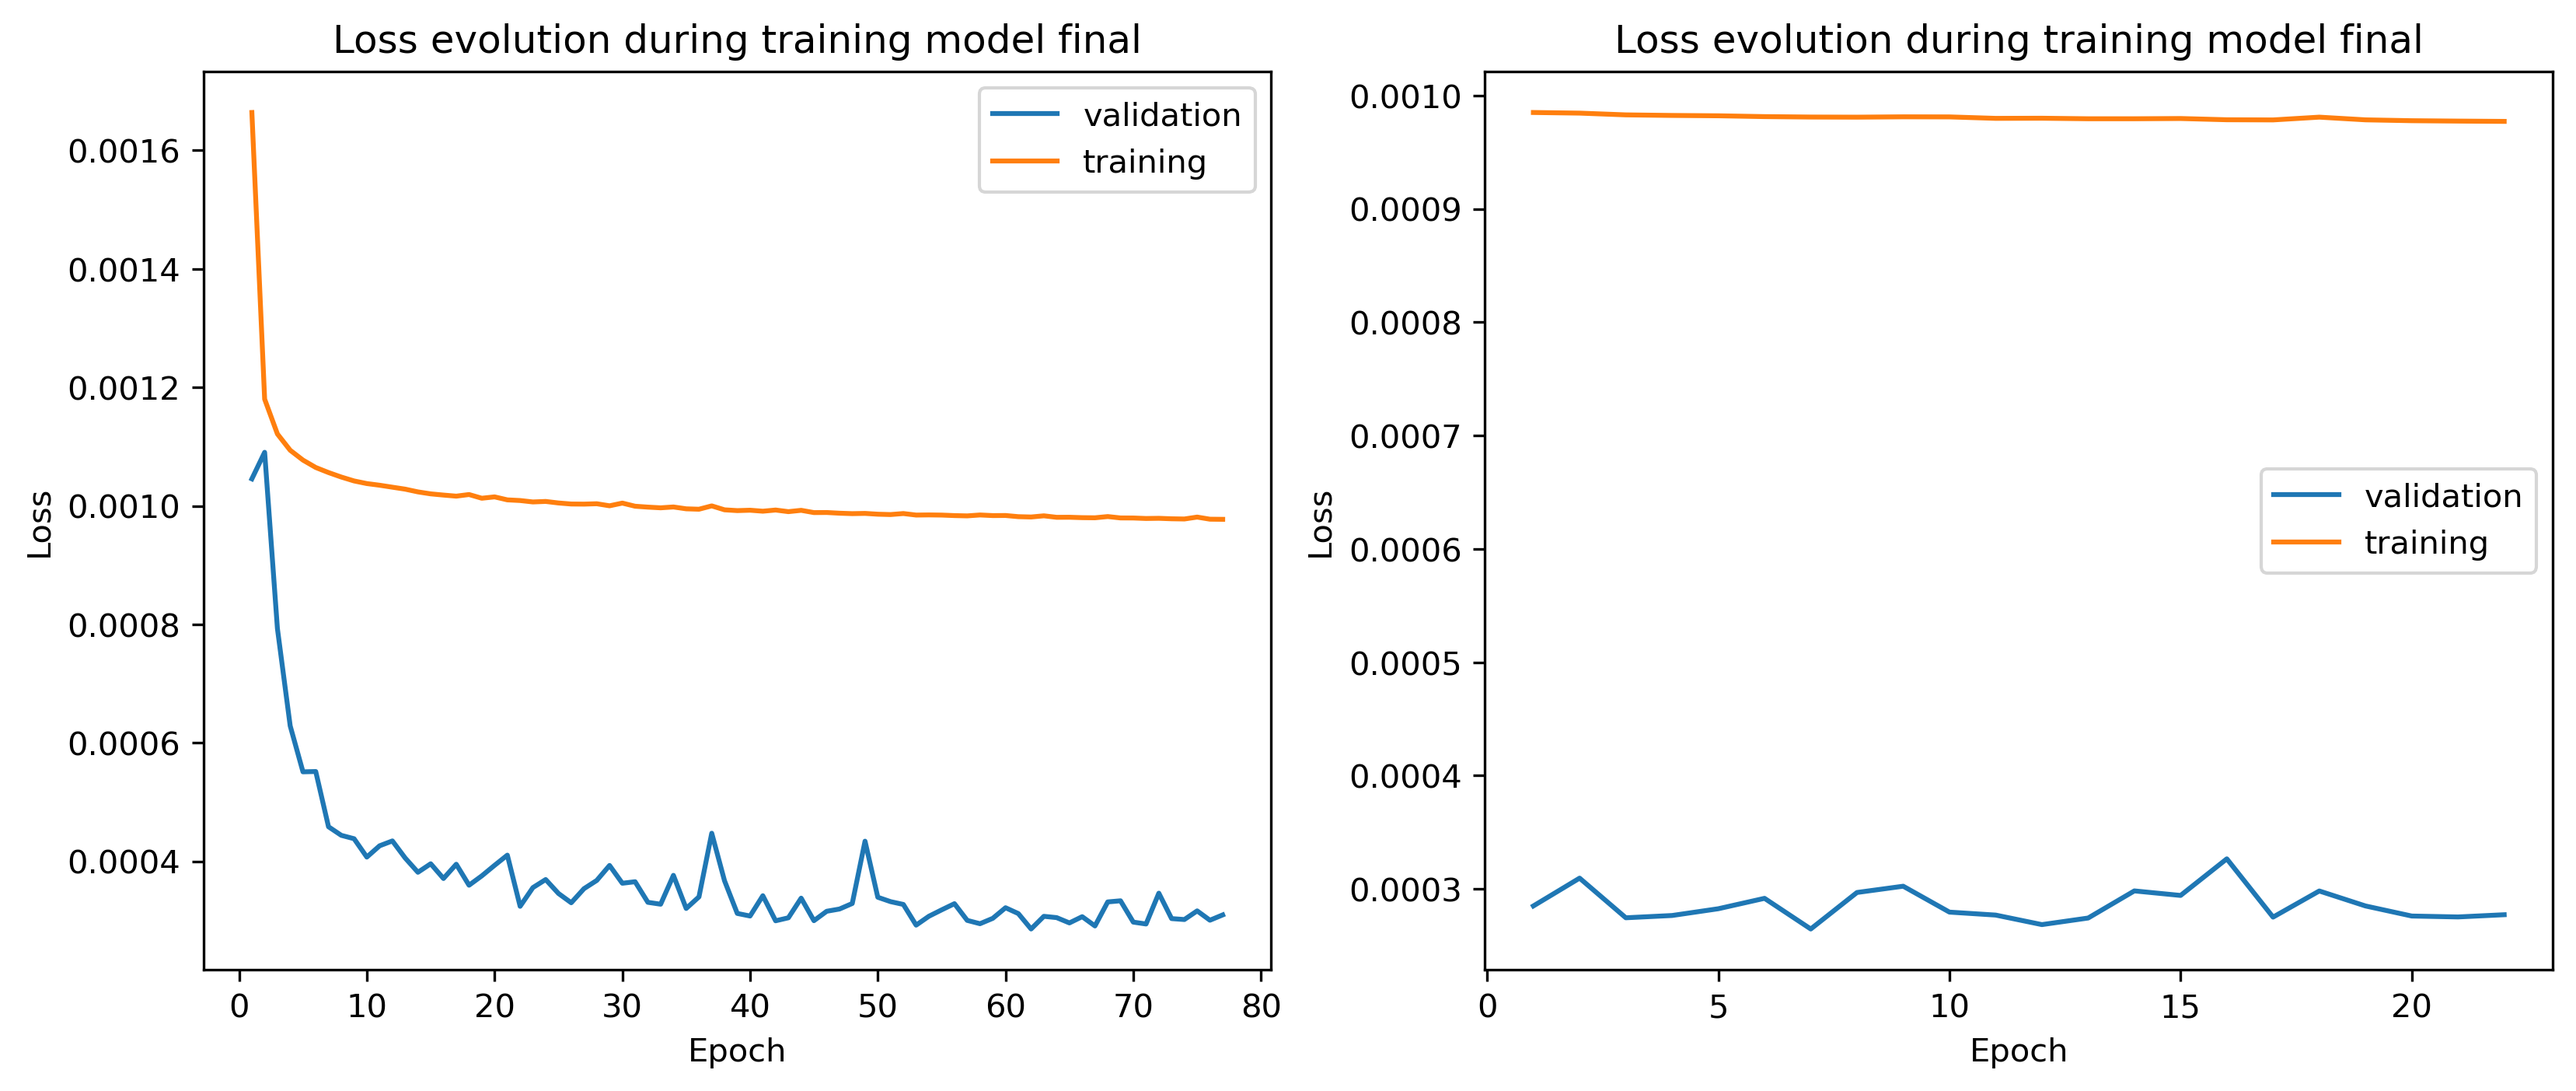

In [7]:
importlib.reload(ae)
importlib.reload(train)
importlib.reload(metrics)

model = ae.AE(latent_dim = 50, n_channels = 3, name = 'final')

#static parameters
max_epochs = 200
criterion = ae.loss_function
batch_size = 150 #100
lr = 1.665e-4

augmentation = True
suffle = False
early_stopping = 15
use_gpu = True

curves_2_0, tiempo_2_0, mse_2_0 = train.train_model(model,
                                            train_subset_0_0,
                                            validation_dataset_0,
                                            test_dataset_0,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

torch.save(model.state_dict(), 'models/model_final.pth')

curves_2_1, tiempo_2_1, mse_2_1 = train.train_model(model,
                                            train_subset_0_1,
                                            validation_dataset_0,
                                            test_dataset_0,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=augmentation,
                                            shuffle_augmentation=suffle,
                                            early_stop=early_stopping,
                                            use_gpu=use_gpu
                                            )

torch.save(model.state_dict(), 'models/model_final.pth')

metrics.show_curves([curves_2_0, curves_2_1], [model, model])

# Linear Probing Training

In [5]:
# linear probing settings
lp_epochs = 200
lp_criterion = nn.CrossEntropyLoss()
lp_batch_size = 100
lp_lr = 1.665e-4
use_gpu = False

import src.probing.train as train_lp

In [ ]:
import src.probing.train as train_lp
importlib.reload(src.probing.train)

model = ae.AE(latent_dim = 50, n_channels = 3, name = 'final')
model.load_state_dict(torch.load('models/model_final.pth'))

lp_model_0 = lp.LinearClassifier(50, 3, 'final_database')

lp_curves_1, lp_tiempo_1, lp_labels_1, lp_pred_1 = train_lp.train_model(model, lp_model_0, train_dataset_0, validation_dataset_0, test_dataset_0, lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)

torch.save(lp_model_0.state_dict(), 'models/lp_model_final.pth')

# Metrics

In [116]:
# settings
importlib.reload(plots)
importlib.reload(metrics)
#umap 
n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
norm = True

In [72]:
print('MSE 1:', mse_1, '\nMSE 2:', mse_2)

MSE 1: 0.0018247352647091878


## Variable database

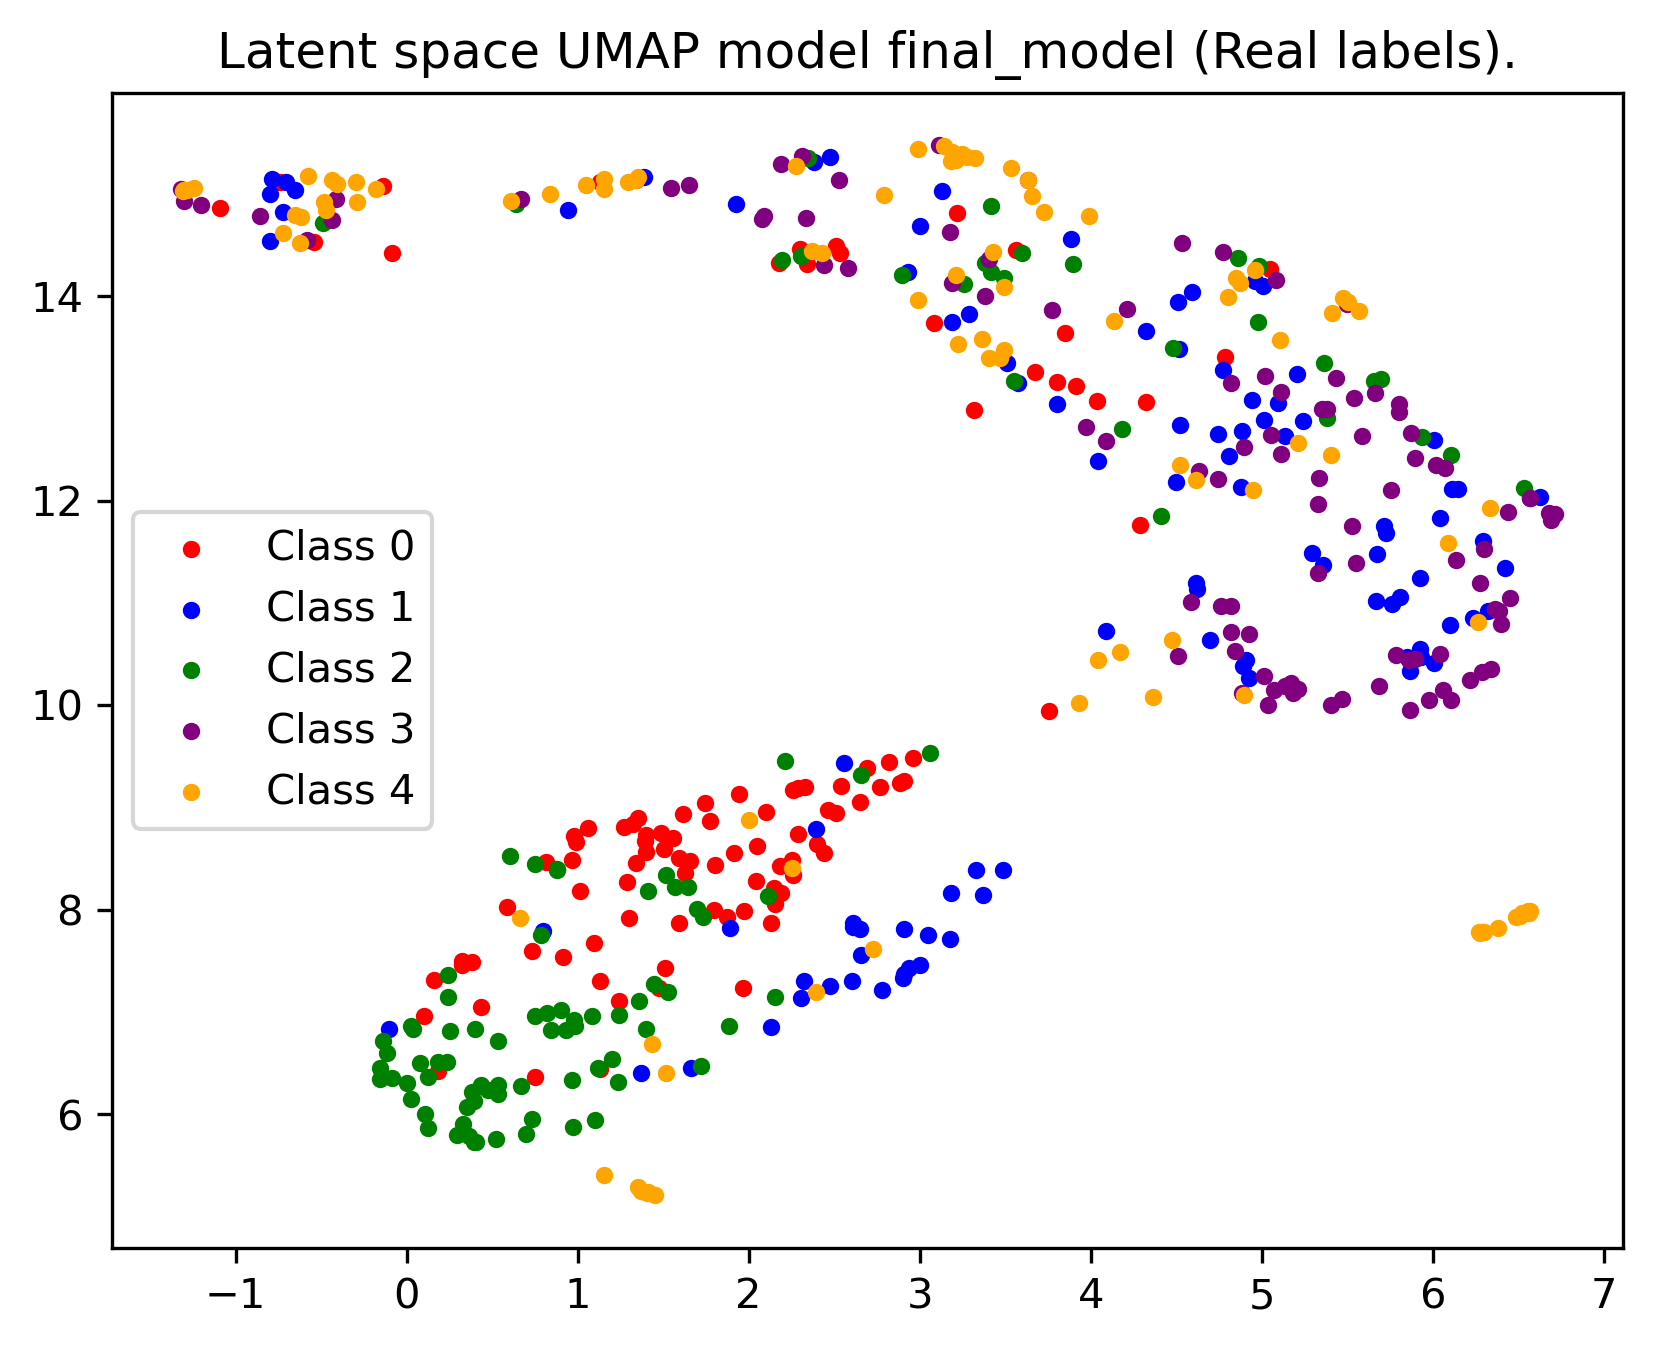

In [117]:
# latent space umap
metrics.plot_umap([model], test_dataset_1.tensors[0], test_class_1, n_neighbors, min_dist, metric, norm)
print()

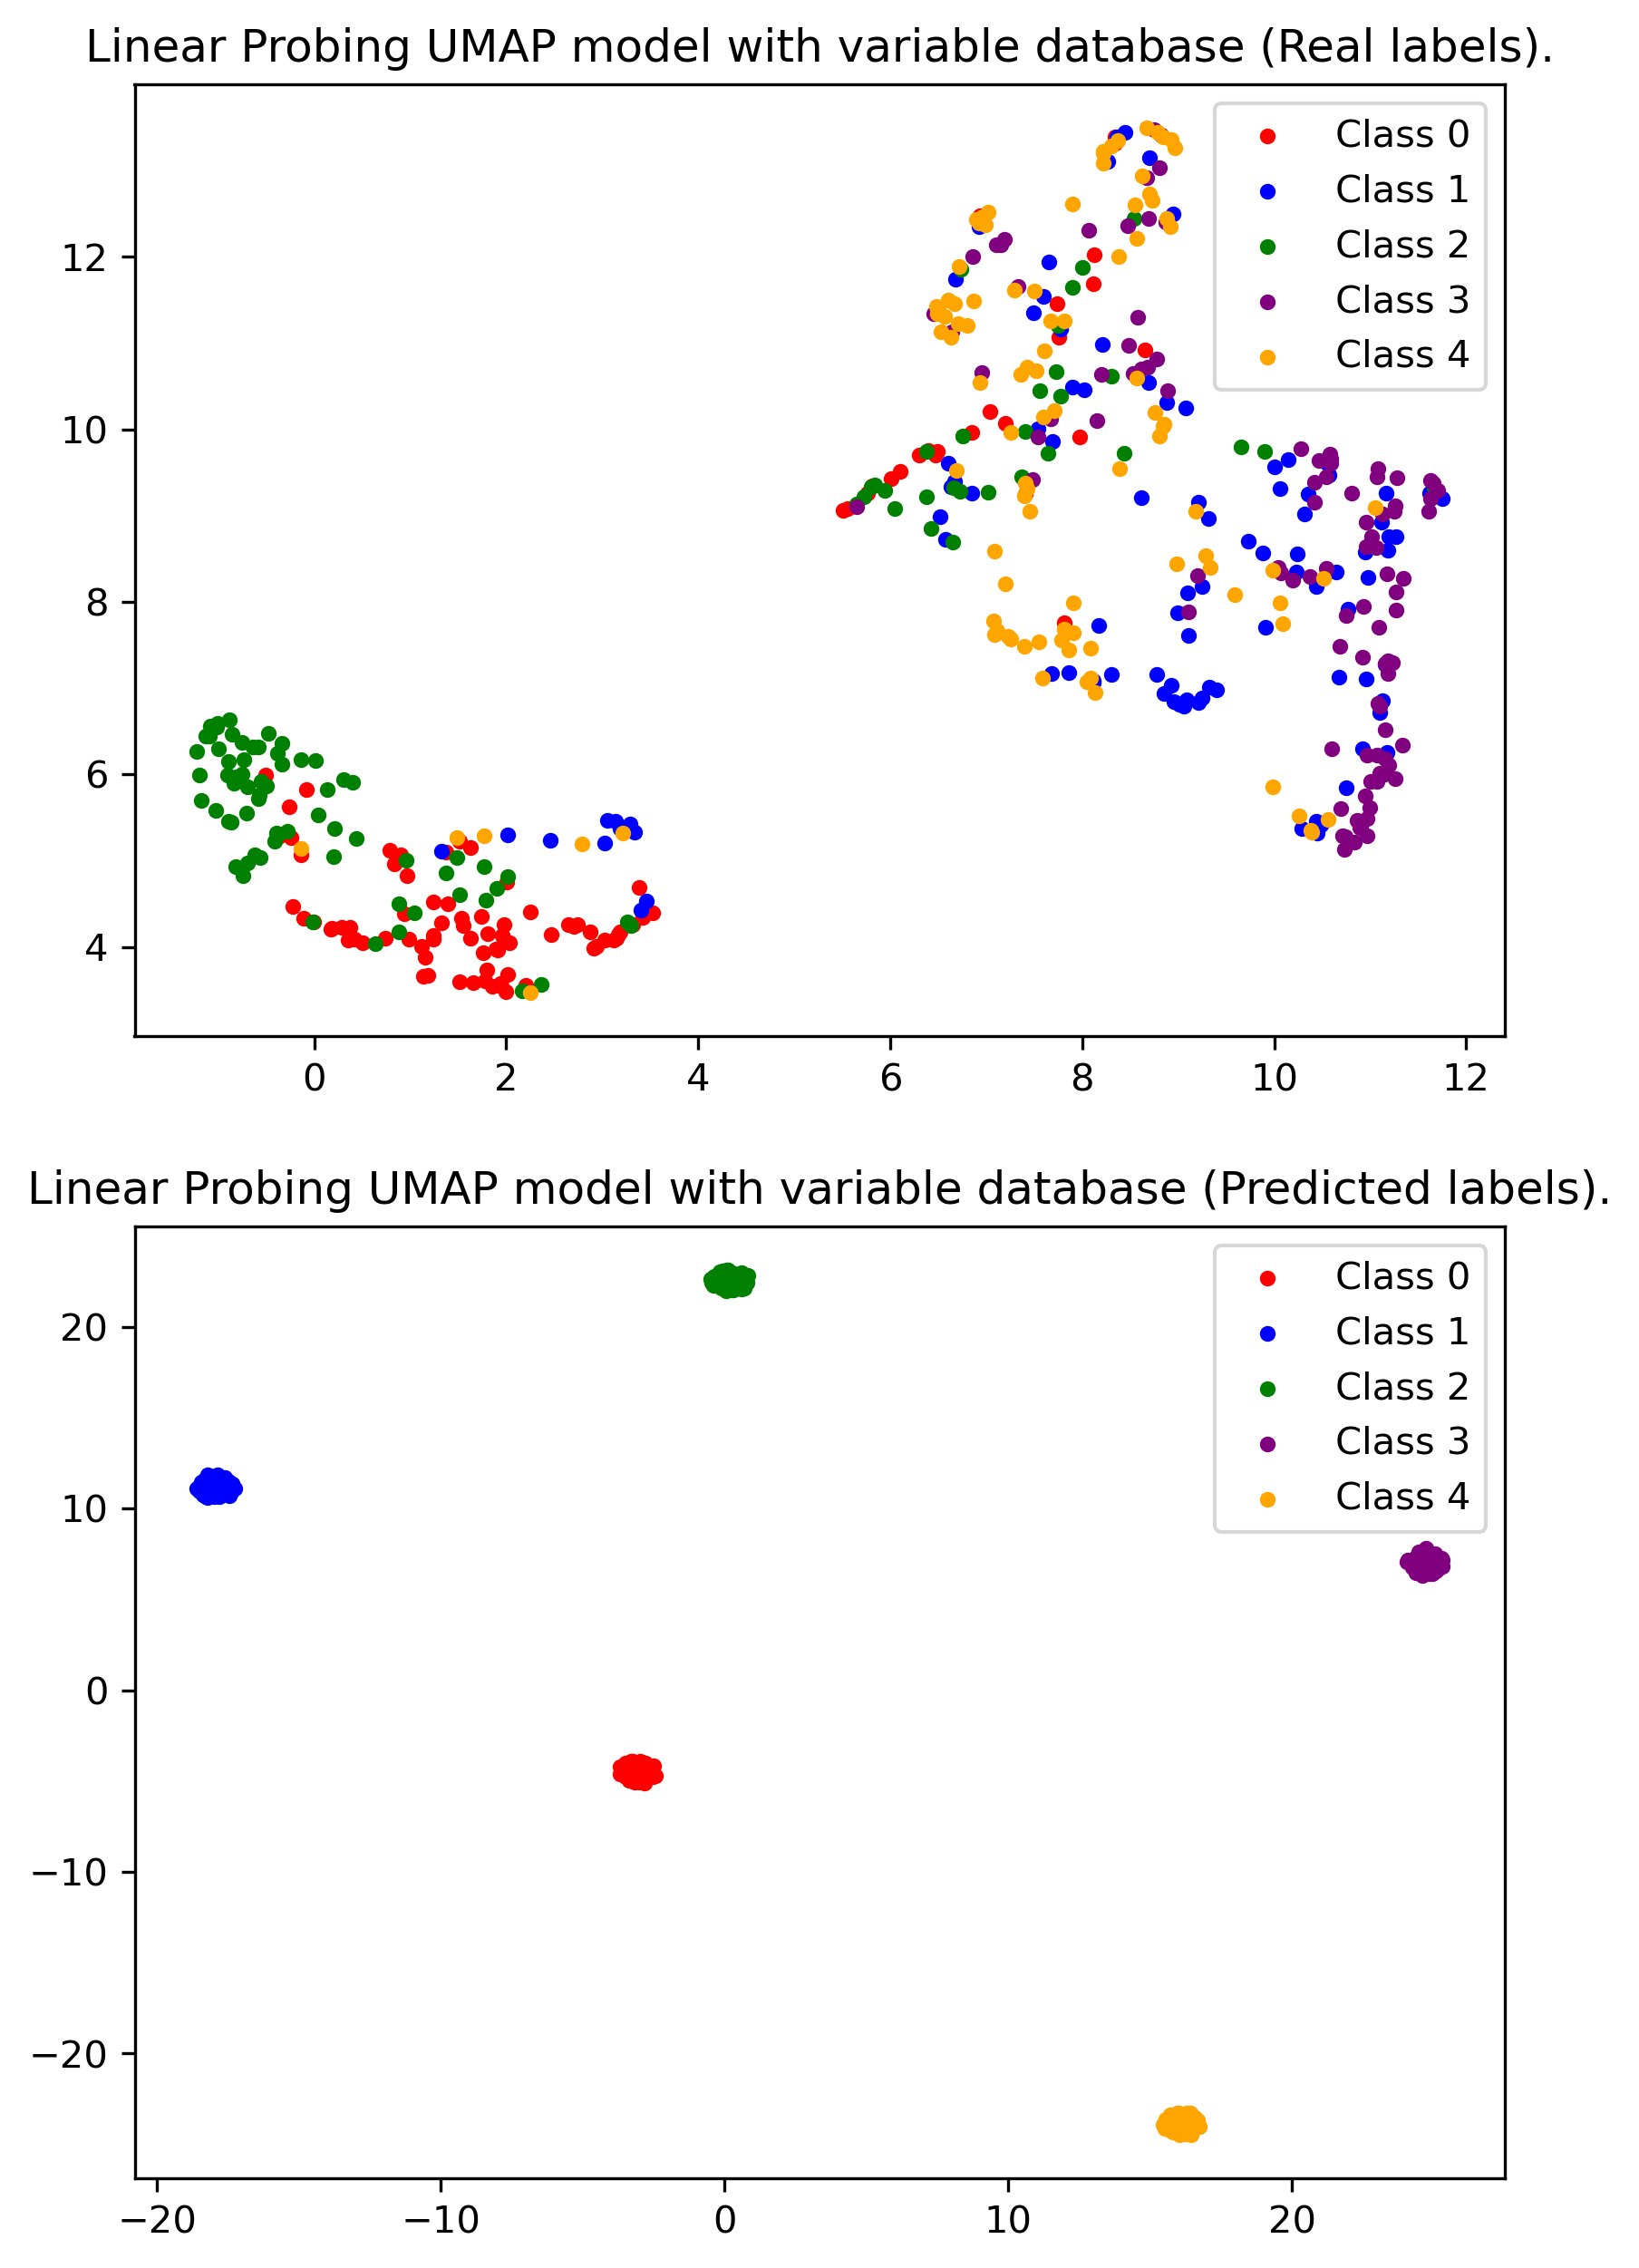

In [118]:
# linear probing umap + confusion matrix
importlib.reload(metrics)

metrics.plot_umap_lp([lp_model_1], test_1, n_neighbors, min_dist, metric, norm)
print()

In [ ]:
# reconstruction examples
plots.plot_example([model], test_dataset_1)
print()

## Final database

In [ ]:
# latent space umap
metrics.plot_umap([model], test_dataset_0.tensors[0], test_class_0, n_neighbors, min_dist, metric, norm)
print()

In [ ]:
# linear probing umap + confusion matrix
metrics.plot_umap_lp([lp_model_2], test_2, n_neighbors, min_dist, metric, norm)
print()

In [ ]:
# reconstruction examples
plots.plot_example([model], test_dataset_0)
print()